In [1]:
import pandas as pd
import sqlite3
import random
import requests

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
from io import BytesIO

In [2]:
conn = sqlite3.connect('data/sqlite/nfl_data.sqlite')

In [3]:
teams_df = pd.read_sql('SELECT * FROM teams', conn).set_index('abbreviation')

In [4]:
games_df = pd.read_sql('SELECT * FROM games', conn).set_index('gameId')

In [5]:
plays_df = pd.read_sql('SELECT * FROM plays', conn).set_index('play_uuid')

In [6]:
# (GITHUB COLAB AI) 
# prompt: load all CSV files with a name like "tracking_week_" into a tracking_df dataframe
import glob
tracking_df = pd.concat(map(pd.read_csv, glob.glob(f'data/nfl-big-data-bowl-2024/*week*.csv')))
# generate same Play-UUID for frame lookup
tracking_df['play_uuid'] = tracking_df['gameId'].astype(str) + '.' + tracking_df['playId'].astype(str)
tracking_df['club'] = tracking_df['club'].replace('LA', 'LAR').replace('WAS', 'WSH')

In [7]:
# tracking_df = pd.read_sql('SELECT * FROM tracking', conn)

In [8]:
snap_formations_df = pd.read_sql('SELECT * FROM snap_formations', conn).set_index('play_uuid')
snap_formations_df.head()

,x0,y0,s0,a0,dis0,o0,dir0,x1,y1,s1,...,s21,a21,dis21,o21,dir21,x22,y22,s22,a22,dis22
play_uuid,,,,,,,,,,,,,,,,,,,,,
2022090800.101,73.13,27.67,0.10,1.14,0.02,273.97,348.75,67.35,29.96,0.07,...,0.00,0.00,0.00,267.12,339.31,72.040001,29.520000,0.04,0.29,0.01
2022090800.1187,71.72,29.54,0.05,0.85,0.01,272.46,55.53,69.25,24.99,0.14,...,0.94,0.81,0.09,87.20,10.33,70.070000,29.610001,0.00,0.00,0.01
2022090800.1254,59.81,23.63,0.00,0.00,0.00,272.98,143.12,42.18,36.75,0.65,...,0.04,0.04,0.02,131.60,216.90,54.689999,23.879999,0.00,0.00,0.00
2022090800.1385,36.64,29.50,0.08,0.88,0.01,273.91,130.33,34.44,33.93,0.49,...,0.00,0.00,0.03,49.70,91.93,34.990002,29.730000,0.00,0.00,0.00
2022090800.1406,18.65,23.35,0.25,1.67,0.02,278.66,52.44,16.13,28.06,0.40,...,0.32,0.18,0.03,117.94,100.45,17.389999,23.340000,0.02,0.02,0.00


In [9]:
# Filter tracking_df for the Ball Snap Frames
ball_snap_df = tracking_df.loc[(tracking_df['event'] == 'ball_snap')] #| (tracking_df['event'] == 'autoevent_ballsnap')]
ball_snap_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
5,2022100600,90,33084.0,Matt Ryan,6,2022-10-06 20:17:05.299999,2.0,IND,left,90.26,23.69,0.20,0.14,0.04,274.45,250.64,ball_snap,2022100600.90
65,2022100600,90,35459.0,Kareem Jackson,6,2022-10-06 20:17:05.299999,22.0,DEN,left,72.17,16.80,0.48,0.94,0.05,119.60,125.33,ball_snap,2022100600.90
125,2022100600,90,42030.0,K'Waun Williams,6,2022-10-06 20:17:05.299999,21.0,DEN,left,80.22,31.04,3.41,2.96,0.35,128.25,199.16,ball_snap,2022100600.90
185,2022100600,90,42393.0,Ronald Darby,6,2022-10-06 20:17:05.299999,23.0,DEN,left,76.83,36.25,0.04,0.14,0.01,73.29,206.98,ball_snap,2022100600.90
245,2022100600,90,43307.0,Ryan Kelly,6,2022-10-06 20:17:05.299999,78.0,IND,left,85.75,23.80,0.08,0.38,0.01,252.44,311.45,ball_snap,2022100600.90


In [10]:
position_counts = ball_snap_df[['play_uuid', 'nflId']].groupby('play_uuid').count()
snap_ids = position_counts.loc[(position_counts['nflId'] == 22)].index
snap_ids

Index(['2022090800.101', '2022090800.1187', '2022090800.1254',
       '2022090800.1385', '2022090800.1406', '2022090800.146',
       '2022090800.1736', '2022090800.191', '2022090800.1946',
       '2022090800.2043',
       ...
       '2022110700.3787', '2022110700.403', '2022110700.443', '2022110700.493',
       '2022110700.546', '2022110700.612', '2022110700.670', '2022110700.80',
       '2022110700.929', '2022110700.950'],
      dtype='object', name='play_uuid', length=6323)

In [11]:
# Create a DF of the plays with all-22 Frames available
all_22_plays_df = plays_df.loc[snap_ids]
all_22_plays_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2,converted
play_uuid,,,,,,,,,,,,,,,,,,,,,
2022090800.101,2022090800,101,47857,Devin Singletary,(13:54) D.Singletary right end to BUF 45 for 7...,1,1,10,BUF,LAR,...,0.600181,-0.014850,0.014850,2.126690,0.562363,None,None,NaN,NaN,0
2022090800.1187,2022090800,1187,47853,Darrell Henderson,(8:48) D.Henderson right tackle to LA 44 for 4...,2,1,10,LAR,BUF,...,0.792763,0.006345,-0.006345,2.123537,-0.042901,None,None,NaN,NaN,0
2022090800.1254,2022090800,1254,46830,Brandon Powell,(7:20) (Shotgun) B.Powell left tackle to BUF 4...,2,1,10,LAR,BUF,...,0.772788,0.008701,-0.008701,3.117542,0.550017,Defensive Holding,None,42395.0,NaN,0
2022090800.1385,2022090800,1385,47853,Darrell Henderson,(4:14) D.Henderson left end to BUF 7 for 18 ya...,2,1,10,LAR,BUF,...,0.764799,0.027923,-0.027923,4.027252,1.463392,None,None,NaN,NaN,1
2022090800.1406,2022090800,1406,47853,Darrell Henderson,(3:42) D.Henderson up the middle to BUF 4 for ...,2,1,7,LAR,BUF,...,0.736876,0.000100,-0.000100,5.490634,0.118456,None,None,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022110700.612,2022110700,612,47896,Justice Hill,(3:44) (Shotgun) J.Hill left end to NO 40 for ...,1,1,10,BAL,NO,...,0.533628,0.047439,-0.047439,3.753480,-1.229170,None,None,NaN,NaN,0
2022110700.670,2022110700,670,46101,Lamar Jackson,(2:09) (Shotgun) L.Jackson left end to NO 24 f...,1,3,1,BAL,NO,...,0.540354,-0.023838,0.023838,3.966451,0.552217,None,None,NaN,NaN,1
2022110700.80,2022110700,80,44879,Alvin Kamara,(14:24) (Shotgun) A.Kamara right tackle to NO ...,1,1,10,NO,BAL,...,0.416139,-0.001371,0.001371,2.335142,-0.482939,None,None,NaN,NaN,0


In [12]:
# filter for tracking frames from the all-22 df and the ball snap event.
# These will all be 22 players and the ball for each play_uuid
all_22_frames_df = ball_snap_df.loc[(ball_snap_df['play_uuid'].isin(snap_ids))]
all_22_frames_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
5,2022100600,90,33084.0,Matt Ryan,6,2022-10-06 20:17:05.299999,2.0,IND,left,90.26,23.69,0.20,0.14,0.04,274.45,250.64,ball_snap,2022100600.90
65,2022100600,90,35459.0,Kareem Jackson,6,2022-10-06 20:17:05.299999,22.0,DEN,left,72.17,16.80,0.48,0.94,0.05,119.60,125.33,ball_snap,2022100600.90
125,2022100600,90,42030.0,K'Waun Williams,6,2022-10-06 20:17:05.299999,21.0,DEN,left,80.22,31.04,3.41,2.96,0.35,128.25,199.16,ball_snap,2022100600.90
185,2022100600,90,42393.0,Ronald Darby,6,2022-10-06 20:17:05.299999,23.0,DEN,left,76.83,36.25,0.04,0.14,0.01,73.29,206.98,ball_snap,2022100600.90
245,2022100600,90,43307.0,Ryan Kelly,6,2022-10-06 20:17:05.299999,78.0,IND,left,85.75,23.80,0.08,0.38,0.01,252.44,311.45,ball_snap,2022100600.90


In [13]:
# Select a random play from the all-22 plays
random_play =  random.randint(0, len(all_22_plays_df))
# Select the play record
play = all_22_plays_df.iloc[random_play]
random_id = play.name
play

gameId                                                                     2022092504
playId                                                                            134
ballCarrierId                                                                   48707
ballCarrierDisplayName                                                 Craig Reynolds
playDescription                     (13:04) C.Reynolds right guard to MIN 34 for n...
quarter                                                                             1
down                                                                                1
yardsToGo                                                                          10
possessionTeam                                                                    DET
defensiveTeam                                                                     MIN
yardlineSide                                                                      MIN
yardlineNumber                                        

In [25]:
play_frames = tracking_df.loc[((tracking_df['gameId'] == play['gameId']) & (tracking_df['playId'] == play['playId']))]
play_frames

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
463105,2022092504,134,37078.0,Patrick Peterson,1,2022-09-25 13:05:06.200000,7.0,MIN,right,83.080000,15.910000,0.47,0.17,0.04,301.02,261.87,NaN,2022092504.134
463106,2022092504,134,37078.0,Patrick Peterson,2,2022-09-25 13:05:06.299999,7.0,MIN,right,83.040000,15.900000,0.45,0.21,0.04,304.20,259.30,NaN,2022092504.134
463107,2022092504,134,37078.0,Patrick Peterson,3,2022-09-25 13:05:06.400000,7.0,MIN,right,83.010000,15.890000,0.40,0.32,0.03,303.21,258.15,NaN,2022092504.134
463108,2022092504,134,37078.0,Patrick Peterson,4,2022-09-25 13:05:06.500000,7.0,MIN,right,82.970000,15.880000,0.37,0.34,0.04,303.21,254.34,NaN,2022092504.134
463109,2022092504,134,37078.0,Patrick Peterson,5,2022-09-25 13:05:06.599999,7.0,MIN,right,82.940000,15.880000,0.32,0.44,0.03,304.05,252.87,NaN,2022092504.134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464181,2022092504,134,NaN,football,43,2022-09-25 13:05:10.400000,NaN,football,right,75.339996,26.600000,1.34,3.10,0.15,NaN,NaN,tackle,2022092504.134
464182,2022092504,134,NaN,football,44,2022-09-25 13:05:10.500000,NaN,football,right,75.330002,26.570000,0.65,3.33,0.04,NaN,NaN,NaN,2022092504.134
464183,2022092504,134,NaN,football,45,2022-09-25 13:05:10.599999,NaN,football,right,75.279999,26.530001,0.21,1.94,0.06,NaN,NaN,NaN,2022092504.134
464184,2022092504,134,NaN,football,46,2022-09-25 13:05:10.700000,NaN,football,right,75.290001,26.520000,0.09,0.99,0.01,NaN,NaN,NaN,2022092504.134


In [27]:
len(tracking_df['nflId'].unique())

1684

In [14]:
# Select the tracking player positions from ball-snap for this play
play_frame = ball_snap_df.loc[(ball_snap_df['play_uuid'] == play.name)]
play_frame

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
463110,2022092504,134,37078.0,Patrick Peterson,6,2022-09-25 13:05:06.700000,7.0,MIN,right,82.910000,15.87,0.27,0.45,0.03,303.15,253.10,ball_snap,2022092504.134
463157,2022092504,134,42388.0,Eric Kendricks,6,2022-09-25 13:05:06.700000,54.0,MIN,right,79.330000,27.86,0.22,0.32,0.02,280.69,218.58,ball_snap,2022092504.134
463204,2022092504,134,42427.0,Jordan Hicks,6,2022-09-25 13:05:06.700000,58.0,MIN,right,79.980000,33.75,0.07,0.75,0.01,244.35,65.53,ball_snap,2022092504.134
463251,2022092504,134,42431.0,Danielle Hunter,6,2022-09-25 13:05:06.700000,99.0,MIN,right,76.750000,35.86,0.04,0.40,0.01,233.89,297.16,ball_snap,2022092504.134
463298,2022092504,134,42465.0,Za'Darius Smith,6,2022-09-25 13:05:06.700000,55.0,MIN,right,76.360000,24.71,0.47,0.21,0.05,320.37,345.94,ball_snap,2022092504.134
463345,2022092504,134,43290.0,Jared Goff,6,2022-09-25 13:05:06.700000,16.0,DET,right,74.310000,29.99,0.00,0.00,0.01,83.11,313.59,ball_snap,2022092504.134
463392,2022092504,134,43305.0,Taylor Decker,6,2022-09-25 13:05:06.700000,68.0,DET,right,74.360000,32.96,0.00,0.00,0.01,84.26,252.53,ball_snap,2022092504.134
463439,2022092504,134,44867.0,Dalvin Tomlinson,6,2022-09-25 13:05:06.700000,94.0,MIN,right,76.390000,28.65,0.07,0.17,0.01,286.42,219.89,ball_snap,2022092504.134
463486,2022092504,134,44930.0,Josh Reynolds,6,2022-09-25 13:05:06.700000,8.0,DET,right,75.090000,38.39,0.00,0.00,0.00,97.17,318.31,ball_snap,2022092504.134
463533,2022092504,134,45721.0,Dan Skipper,6,2022-09-25 13:05:06.700000,70.0,DET,right,74.730000,31.48,0.00,0.15,0.00,94.64,268.42,ball_snap,2022092504.134


In [15]:
last_frame_id = tracking_df.loc[(tracking_df['play_uuid'] == play.name)]['frameId'].max()
last_frame = tracking_df.loc[((tracking_df['play_uuid'] == play.name) & (tracking_df['frameId'] == last_frame_id))]
last_frame

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
463151,2022092504,134,37078.0,Patrick Peterson,47,2022-09-25 13:05:10.799999,7.0,MIN,right,77.170000,22.72,3.00,2.42,0.31,301.70,320.48,NaN,2022092504.134
463198,2022092504,134,42388.0,Eric Kendricks,47,2022-09-25 13:05:10.799999,54.0,MIN,right,75.470000,26.67,1.15,0.98,0.15,228.87,257.50,NaN,2022092504.134
463245,2022092504,134,42427.0,Jordan Hicks,47,2022-09-25 13:05:10.799999,58.0,MIN,right,80.320000,29.82,2.10,1.52,0.20,239.70,202.19,NaN,2022092504.134
463292,2022092504,134,42431.0,Danielle Hunter,47,2022-09-25 13:05:10.799999,99.0,MIN,right,78.160000,29.48,2.38,2.64,0.25,202.52,161.93,NaN,2022092504.134
463339,2022092504,134,42465.0,Za'Darius Smith,47,2022-09-25 13:05:10.799999,55.0,MIN,right,70.970000,32.29,0.46,2.96,0.05,173.11,241.87,NaN,2022092504.134
463386,2022092504,134,43290.0,Jared Goff,47,2022-09-25 13:05:10.799999,16.0,DET,right,65.930000,31.65,0.75,0.68,0.07,117.12,96.90,NaN,2022092504.134
463433,2022092504,134,43305.0,Taylor Decker,47,2022-09-25 13:05:10.799999,68.0,DET,right,74.080000,36.37,1.33,1.30,0.14,78.06,6.87,NaN,2022092504.134
463480,2022092504,134,44867.0,Dalvin Tomlinson,47,2022-09-25 13:05:10.799999,94.0,MIN,right,76.020000,27.54,1.75,2.20,0.18,194.28,192.35,NaN,2022092504.134
463527,2022092504,134,44930.0,Josh Reynolds,47,2022-09-25 13:05:10.799999,8.0,DET,right,80.030000,26.56,2.31,2.79,0.24,252.87,225.24,NaN,2022092504.134
463574,2022092504,134,45721.0,Dan Skipper,47,2022-09-25 13:05:10.799999,70.0,DET,right,70.940000,33.90,3.06,1.95,0.32,167.70,325.21,NaN,2022092504.134


In [16]:
# Select the game for this play
game = games_df.loc[play['gameId']]
game

season                     2022
week                          3
gameDate             09/25/2022
gameTimeEastern        13:00:00
homeTeamAbbr                MIN
visitorTeamAbbr             DET
homeFinalScore               28
visitorFinalScore            24
Name: 2022092504, dtype: object

In [17]:
# Load the Home team logo from the ESPN API 
response = requests.get(teams_df.loc[game['homeTeamAbbr']]['logo'])
home_img = Image.open(BytesIO(response.content))
# Load the away team logo from the ESPN API
response = requests.get(teams_df.loc[game['visitorTeamAbbr']]['logo'])
away_img = Image.open(BytesIO(response.content))

In [18]:
# Initialize team colors from the ESPN API
teams = play_frame['club'].unique()
colors = {teams[0]: mcolors.to_rgba('#' + teams_df.loc[teams[0]]['color']), 
          teams[1]: mcolors.to_rgba('#' + teams_df.loc[teams[1]]['color']), 
          'football': 'brown'}
alt_colors = {teams[0]: mcolors.to_rgba('#' + teams_df.loc[teams[0]]['alternateColor']), 
          teams[1]: mcolors.to_rgba('#' + teams_df.loc[teams[1]]['alternateColor']), 
          'football': 'yellow'}

/var/folders/m8/xlwp526d3sxf6fyr2v802l_80000gn/T/ipykernel_83076/4208403530.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(play_frame[play_frame['club'] == team]['x'], play_frame[play_frame['club'] == team]['y']


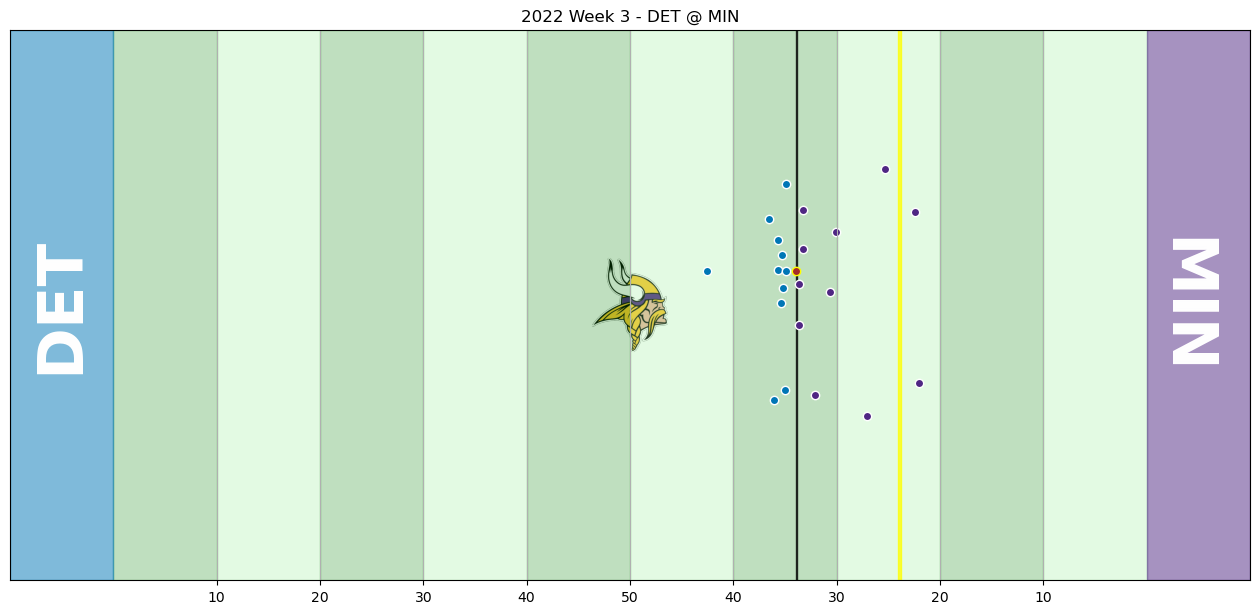

/var/folders/m8/xlwp526d3sxf6fyr2v802l_80000gn/T/ipykernel_83076/4208403530.py:124: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(last_frame[last_frame['club'] == team]['x'], last_frame[last_frame['club'] == team]['y']


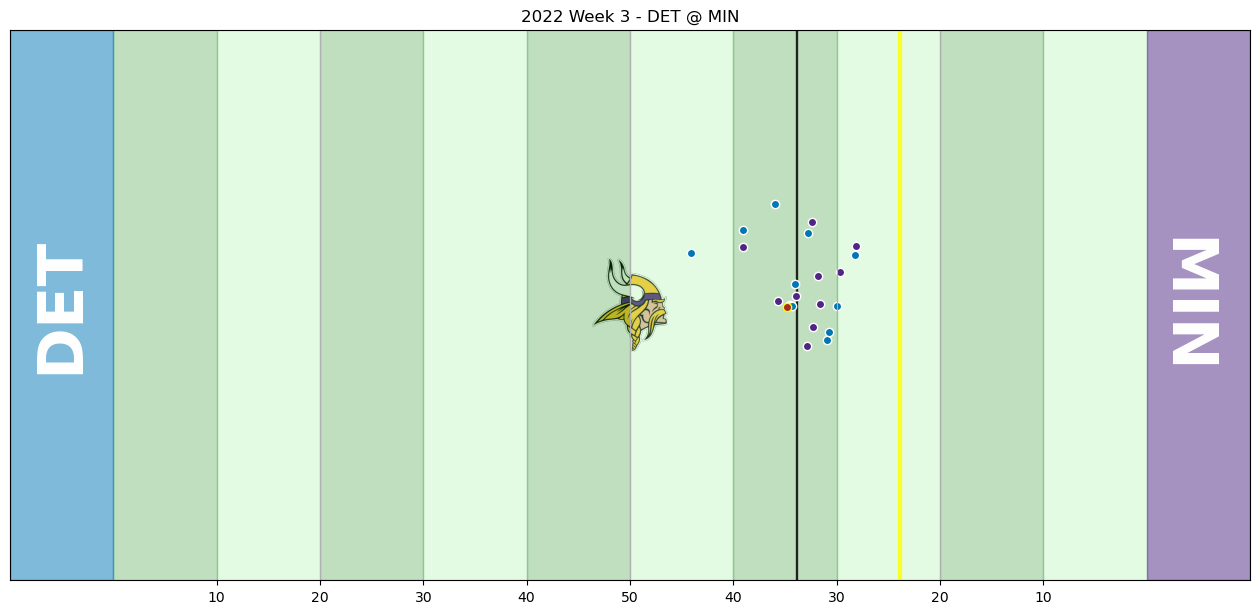

In [19]:
# Build Field and Play formation plot with Matplotlib

# Init figure and title
plt.figure(figsize=(16, 8))
plt.title(f"{game['season']} Week {game['week']} - {game['visitorTeamAbbr']} @ {game['homeTeamAbbr']}")

# Set x and y scales
plt.xlim(0, 120)  # Adjust the limits according to your data
plt.ylim(0, 53.3)  # Adjust the limits according to your data

# Create vertical bands of green and lightgreen for the field
for i in range(10, 101, 20):    
    plt.axvspan(i, i+10, color='green', alpha=0.25)
    plt.axvspan(i+10, i+20, color='lightgreen', alpha=0.25)

# Hide y-axis labels
plt.yticks(ticks=[], labels=[])

# Yard line labels
plt.xticks(ticks=[20,30,40,50,60,70,80,90,100],
           labels=['10','20','30','40','50','40','30','20','10'])

# Determine play orientation - which team is to the right
x_max = max(play_frame['x'])
max_team = play_frame.loc[(play_frame['x'] == x_max)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(max_team, xy=[113.5, 26.65], xytext=[113.5, 26.65], fontsize=45, 
            fontweight='bold',color='white', rotation=270,ha='center', va='center')
plt.axvspan(110, 120, color=colors[max_team], alpha=0.5)

# Determine play orientation - team to the left
x_min = min(play_frame['x'])
min_team = play_frame.loc[(play_frame['x'] == x_min)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(min_team, xy=[5,26.65], xytext=[5,26.65], fontsize=45, fontweight='bold',
             color='white', rotation=90,ha='center', va='center')
plt.axvspan(0, 10, color=colors[min_team], alpha=0.5)

# Plot home team logo at 50 yard line
plt.imshow(home_img, extent=[55,65,21.65,31.65])

# Determine x Position for First Down marker
if play_frame.iloc[2]['playDirection'] == 'right':
    first_down = play_frame.iloc[22]['x'] + play['yardsToGo']
else:
    first_down = play_frame.iloc[22]['x'] - play['yardsToGo']

# Plot first down and line of scrimmage markers
plt.axvspan(first_down-0.125, first_down+0.125, color='yellow', alpha=0.75)
plt.axvspan(play_frame.iloc[22]['x']-0.05, play_frame.iloc[22]['x']+0.05, color='black', alpha=0.75)

# Scatter plot for player and football positions
for team, color in colors.items():
    if team == 'football':
        edge = 'yellow'
    else:
        edge = 'white'
    plt.scatter(play_frame[play_frame['club'] == team]['x'], play_frame[play_frame['club'] == team]['y']
                ,c=color, label=team, alpha=1, edgecolor=edge)

# Show plot
plt.grid(True, axis='x')
plt.show()

# Init figure and title
plt.figure(figsize=(16, 8))
plt.title(f"{game['season']} Week {game['week']} - {game['visitorTeamAbbr']} @ {game['homeTeamAbbr']}")

# Set x and y scales
plt.xlim(0, 120)  # Adjust the limits according to your data
plt.ylim(0, 53.3)  # Adjust the limits according to your data

# Create vertical bands of green and lightgreen for the field
for i in range(10, 101, 20):    
    plt.axvspan(i, i+10, color='green', alpha=0.25)
    plt.axvspan(i+10, i+20, color='lightgreen', alpha=0.25)

# Hide y-axis labels
plt.yticks(ticks=[], labels=[])

# Yard line labels
plt.xticks(ticks=[20,30,40,50,60,70,80,90,100],
           labels=['10','20','30','40','50','40','30','20','10'])

# Determine play orientation - which team is to the right
x_max = max(play_frame['x'])
max_team = play_frame.loc[(play_frame['x'] == x_max)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(max_team, xy=[113.5, 26.65], xytext=[113.5, 26.65], fontsize=45, 
            fontweight='bold',color='white', rotation=270,ha='center', va='center')
plt.axvspan(110, 120, color=colors[max_team], alpha=0.5)

# Determine play orientation - team to the left
x_min = min(play_frame['x'])
min_team = play_frame.loc[(play_frame['x'] == x_min)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(min_team, xy=[5,26.65], xytext=[5,26.65], fontsize=45, fontweight='bold',
             color='white', rotation=90,ha='center', va='center')
plt.axvspan(0, 10, color=colors[min_team], alpha=0.5)

# Plot home team logo at 50 yard line
plt.imshow(home_img, extent=[55,65,21.65,31.65])

# Determine x Position for First Down marker
if play_frame.iloc[2]['playDirection'] == 'right':
    first_down = play_frame.iloc[22]['x'] + play['yardsToGo']
else:
    first_down = play_frame.iloc[22]['x'] - play['yardsToGo']

# Plot first down and line of scrimmage markers
plt.axvspan(first_down-0.125, first_down+0.125, color='yellow', alpha=0.75)
plt.axvspan(play_frame.iloc[22]['x']-0.05, play_frame.iloc[22]['x']+0.05, color='black', alpha=0.75)

# Scatter plot for player and football positions
for team, color in colors.items():
    if team == 'football':
        edge = 'yellow'
    else:
        edge = 'white'
    plt.scatter(last_frame[last_frame['club'] == team]['x'], last_frame[last_frame['club'] == team]['y']
                ,c=color, label=team, alpha=1, edgecolor=edge)

# Show plot
plt.grid(True, axis='x')
plt.show()

